# Machine learning with SDSS data

Adapted from AstroHackWeek [previous AstroHackWeek demo](https://github.com/AstroHackWeek/AstroHackWeek2016/blob/master/day2-machine-learning/machine-learning-on-SDSS.ipynb) by J. S. Bloom (2014, 2016).

We're going to use data from the [SDSS skyserver SQL server](http://skyserver.sdss3.org/public/en/tools/search/sql.aspx). For more information on this data I found a [terse description of the fields in the table](http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+SpecPhoto+V
) and [some details of the preprocessing](http://skyserver.sdss.org/dr1/en/help/docs/algorithm.asp). An example query (you won't have to do this yourself) to get two types of photometry (aperature and petrosian), corrected for extinction, for 1000 QSO sources with redshifts:

```
SELECT *,dered_u - mag_u AS diff_u, dered_g - mag_g AS diff_g, dered_r - mag_r AS diff_g, dered_i - mag_i AS diff_i, dered_z - mag_z AS diff_z from
(SELECT top 1000
objid, ra, dec, dered_u,dered_g,dered_r,dered_i,dered_z,psfmag_u-extinction_u AS mag_u,
psfmag_g-extinction_g AS mag_g, psfmag_r-extinction_r AS mag_r, psfmag_i-extinction_i AS mag_i,psfmag_z-extinction_z AS mag_z,z AS spec_z,dered_u - dered_g AS u_g_color, 
dered_g - dered_r AS g_r_color,dered_r - dered_i AS r_i_color,dered_i - dered_z AS i_z_color,class
FROM SpecPhoto 
WHERE 
 (class = 'QSO')
 ) as sp
```

J. S. Bloom already ran some queries like this and saved them as `csv`, and removed the first line containing `#Table` from the file. The next cell will download one of these files, with data from 10,000 QSO sources:

In [26]:
import os
if os.path.exists('qso10000.csv'):
    print('Have already downloaded data.')
else:
    os.system('wget https://gist.githubusercontent.com/anonymous/53781fe86383c435ff10/raw/4cc80a638e8e083775caec3005ae2feaf92b8d5b/qso10000.csv')

Have already downloaded data.


## First look at the data

In [27]:
import pandas as pd
pd.set_option('display.max_columns', None)

qso = pd.read_csv('qso10000.csv', index_col=0)
print(qso.columns) # to see all column names without scrolling before looking at sample of table
qso.head()

Index(['ra', 'dec', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',
       'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'spec_z', 'u_g_color',
       'g_r_color', 'r_i_color', 'i_z_color', 'class', 'diff_u', 'diff_g',
       'diff_g1', 'diff_i', 'diff_z'],
      dtype='object')


,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,mag_r,mag_i,mag_z,spec_z,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_g1,diff_i,diff_z
objid,,,,,,,,,,,,,,,,,,,,,,,
1237648720142532813,146.90229,-0.984913,19.64289,19.31131,19.25328,19.15353,19.13345,19.71604,19.37595,19.32818,19.24847,19.21259,0.652417,0.331583,0.058027,0.099751,0.020077,QSO,-0.073151,-0.064648,-0.074903,-0.094942,-0.079136
1237658425156829371,142.45853,6.646406,19.39569,19.34811,19.16626,18.93152,19.06013,19.40327,19.36566,19.18335,18.94222,19.08077,1.537123,0.047575,0.181847,0.234743,-0.128612,QSO,-0.007589,-0.017550,-0.017090,-0.010700,-0.020636
1237660413189095710,143.15770,8.175363,19.10362,18.88904,18.70672,18.58508,18.61328,19.11102,18.88857,18.70458,18.57886,18.62583,1.467101,0.214582,0.182318,0.121645,-0.028202,QSO,-0.007397,0.000473,0.002148,0.006218,-0.012548
1237660412651962520,142.49264,7.800944,19.88820,19.75146,19.52941,19.65000,19.52470,19.88709,19.75292,19.53512,19.67052,19.50256,1.014217,0.136745,0.222052,-0.120590,0.125301,QSO,0.001118,-0.001457,-0.005716,-0.020527,0.022139
1237658493336944662,142.64367,7.917698,18.45897,18.40651,18.15901,17.77130,17.75986,18.55725,18.55002,18.40316,18.01008,18.03100,0.215603,0.052462,0.247498,0.387709,0.011444,QSO,-0.098282,-0.143515,-0.244150,-0.238779,-0.271137


**We'll be predicting redshift 'spec_z' from the photometry data.**

Following Bloom we'll end up dropping the position on the sky 'ra' and 'dec'. (To discuss: why? Might it ever help to keep them?)

But before discarding them, we'll make a quick plot of the 'ra' values in the order they appear in the table:

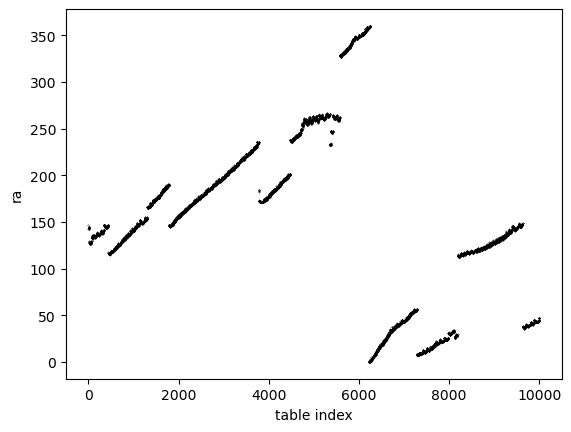

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(qso['ra'].values, 'k.', ms=0.5)
plt.xlabel('table index'); plt.ylabel('ra');

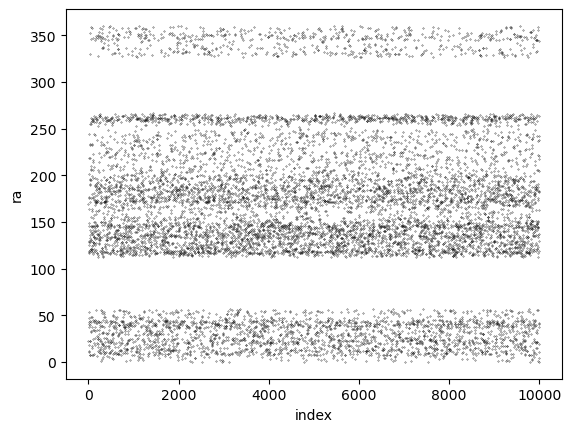

In [29]:
# The data not in a random order. Knee-jerk reaction: shuffle it!
import numpy as np
qso = qso.iloc[np.random.RandomState(seed=12345).permutation(len(qso))]
plt.plot(qso['ra'].values, 'k.', ms=0.5)
plt.xlabel('index'); plt.ylabel('ra');

## Setting up the output to predict

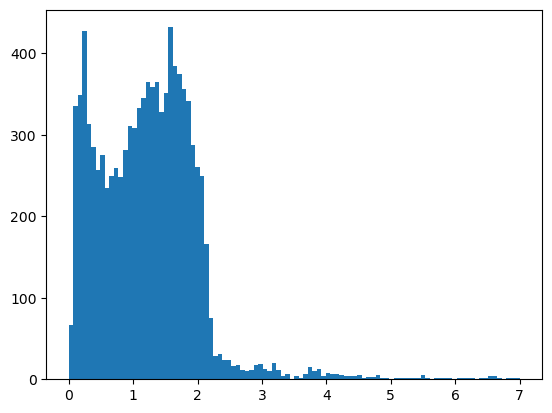

In [30]:
# We want to predict redshifts:
plt.hist(qso['spec_z'], 100, histtype='stepfilled');

In [31]:
if qso['spec_z'].min() < 0:
    qso['spec_z'] += 2*abs(qso['spec_z'].min()) ## HACK. slightly -ve redshifts?

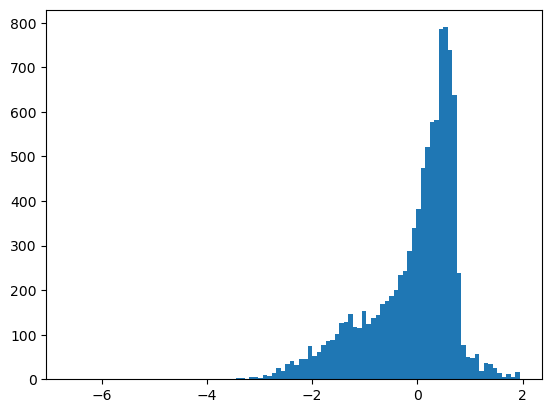

In [32]:
# Or maybe *log* redshifts...
import numpy as np
qso_y = np.log(qso['spec_z'])
plt.hist(qso_y, 100, histtype='stepfilled');

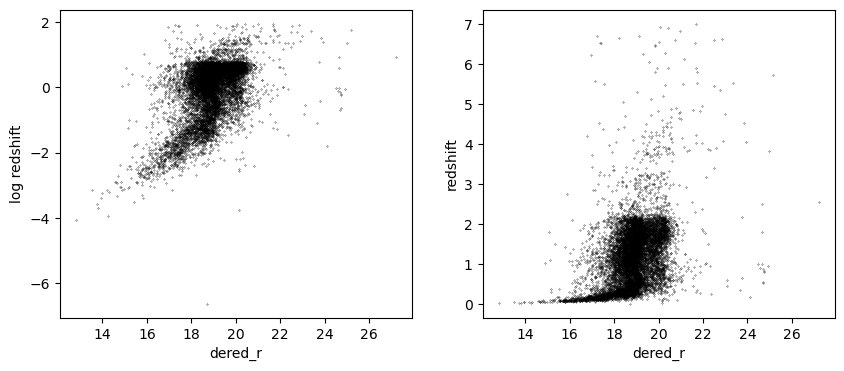

In [33]:
mask = qso['dered_r'] > -9000  # we'll see why shortly...
plt.figure(figsize=[10, 4]);
plt.subplot(1, 2, 1); plt.plot(qso['dered_r'][mask], qso_y[mask], 'k.', ms=0.5)
plt.xlabel('dered_r'); plt.ylabel('log redshift')
plt.subplot(1, 2, 2); plt.plot(qso['dered_r'][mask], np.exp(qso_y[mask]), 'k.', ms=0.5)
plt.xlabel('dered_r'); plt.ylabel('redshift');

## Setting up the inputs to predict from

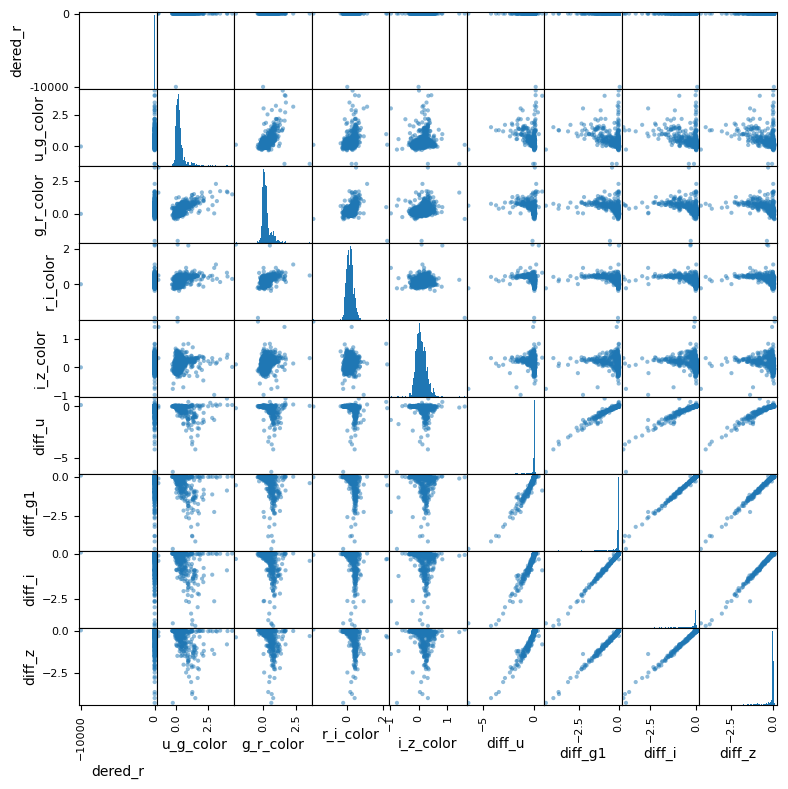

In [34]:
# What about the inputs?
column_subset = ['dered_r', 'u_g_color', 'g_r_color',
                 'r_i_color', 'i_z_color', 'diff_u', 'diff_g1', 'diff_i', 'diff_z']
pd.plotting.scatter_matrix(qso[:1000][column_subset], figsize=[9,9], hist_kwds={'bins': 100});

# I wanted to use DFM's corner here... nicer for publication output, but proved more of a pain to get working...

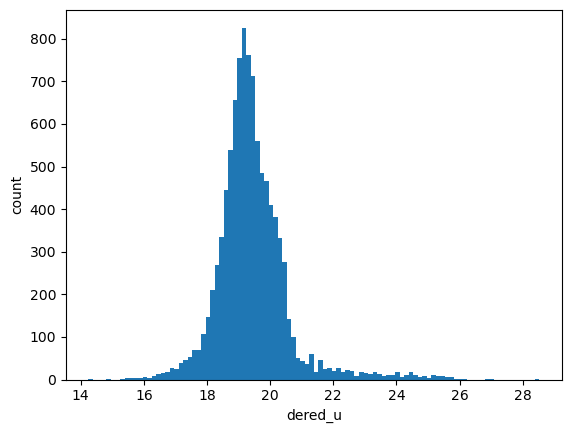

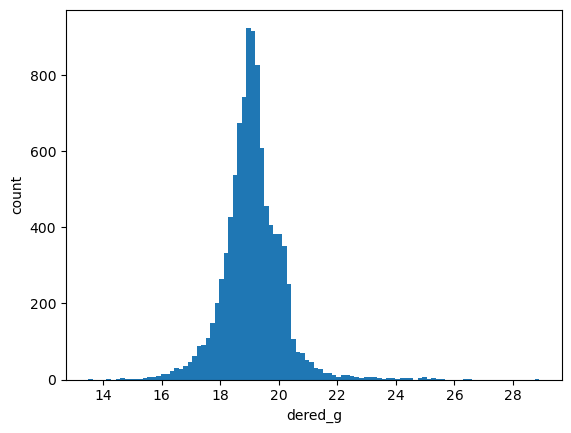

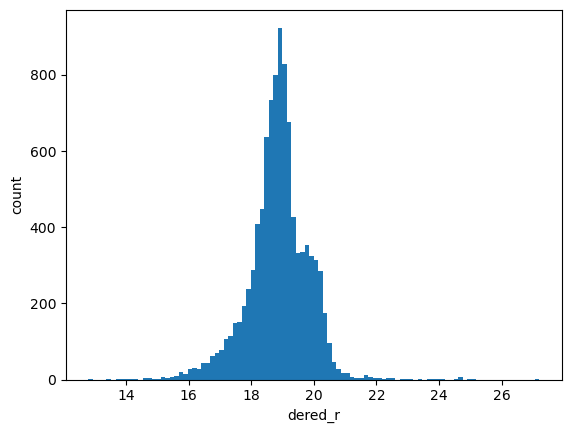

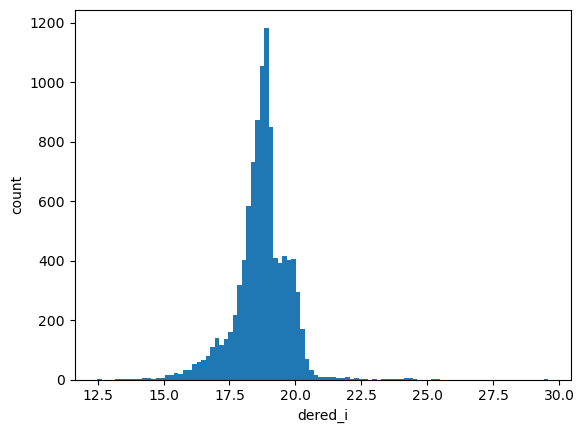

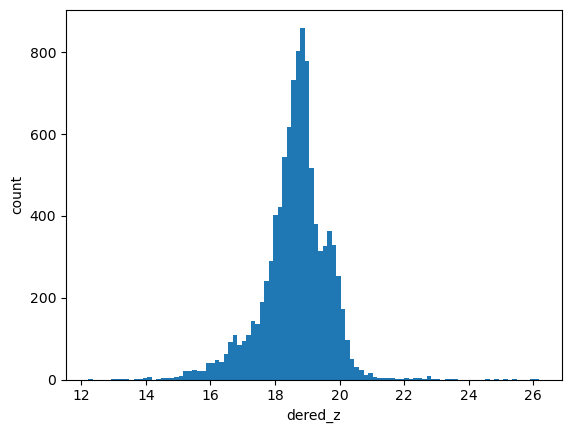

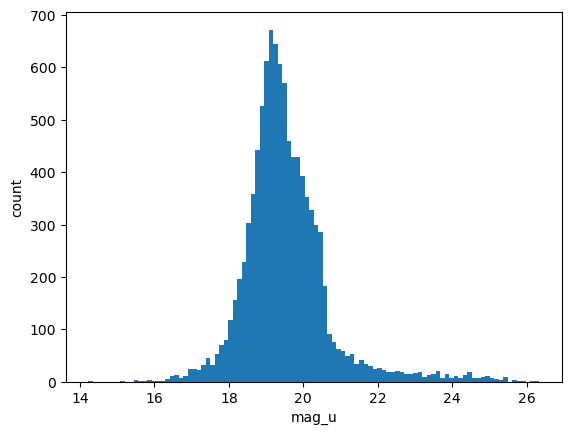

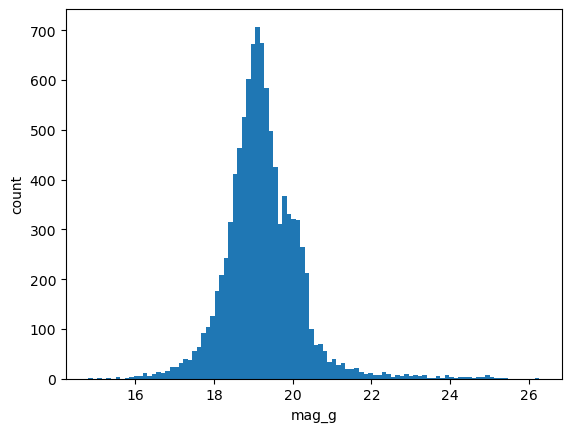

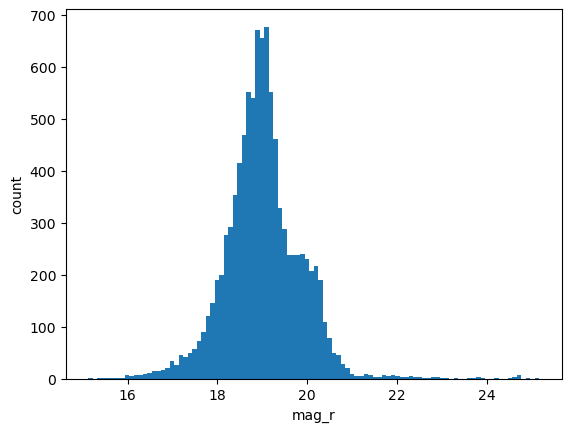

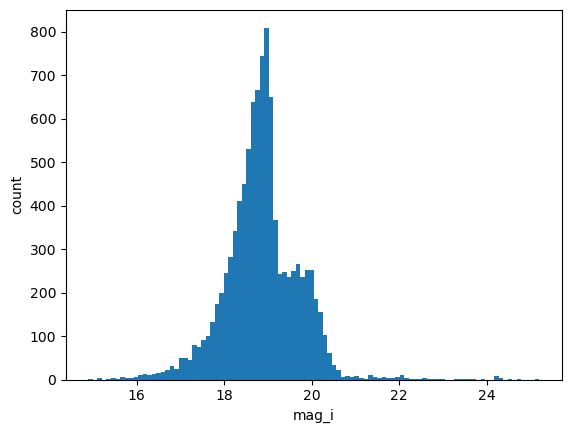

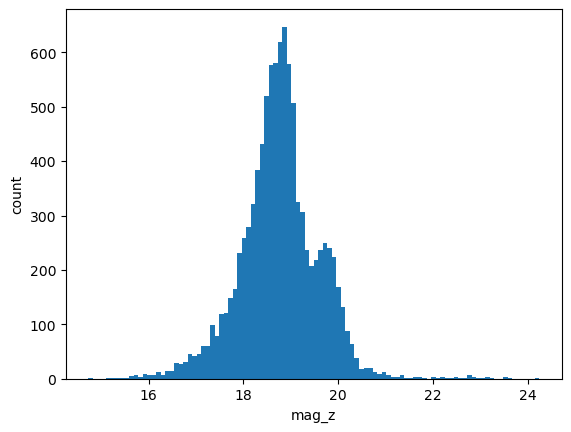

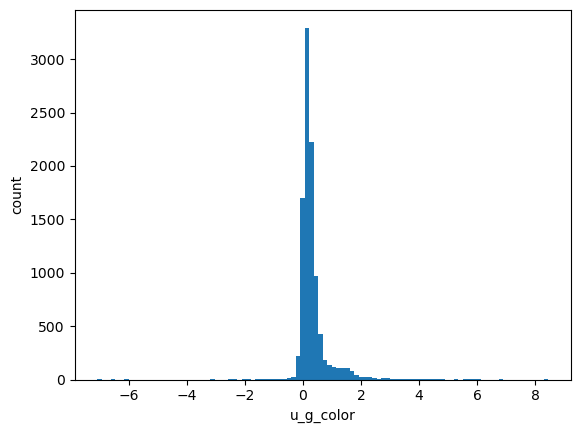

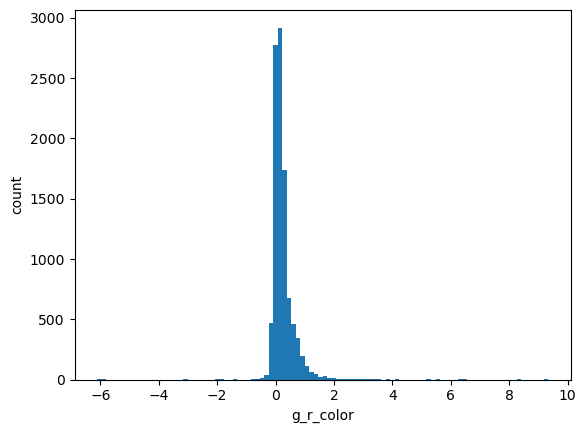

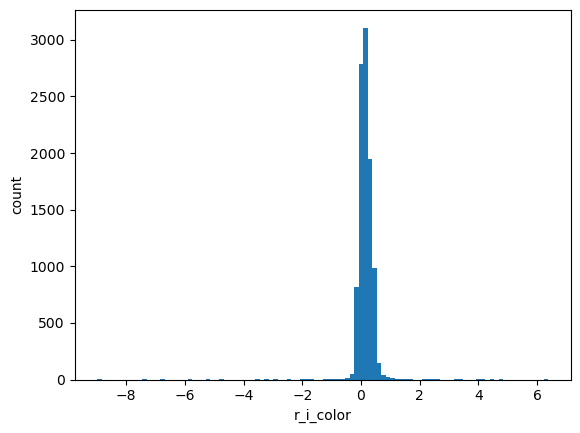

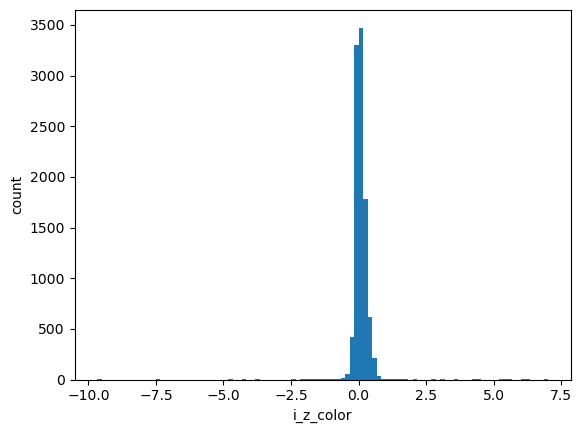

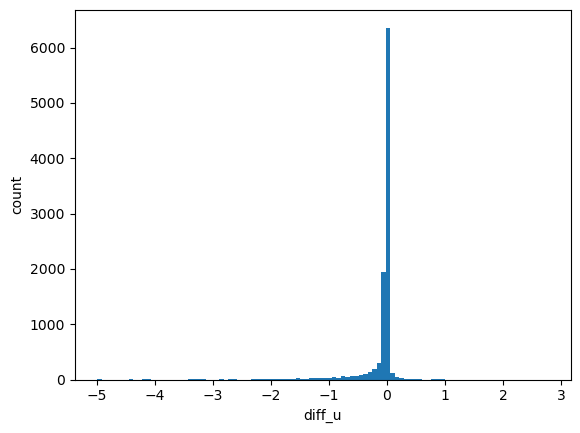

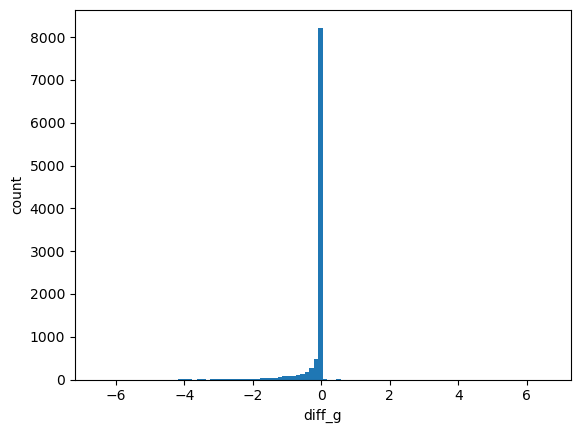

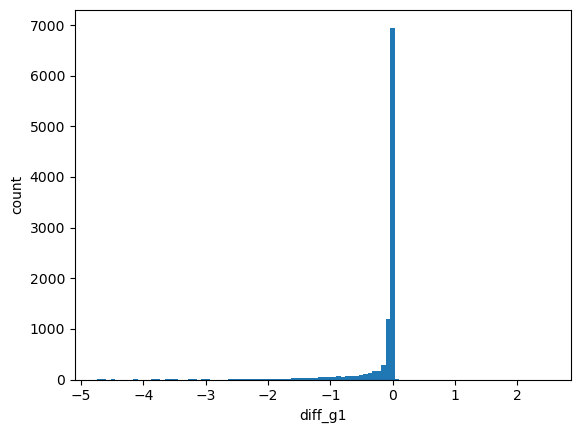

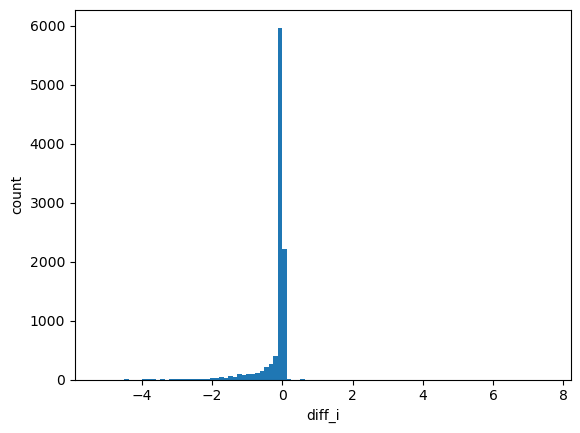

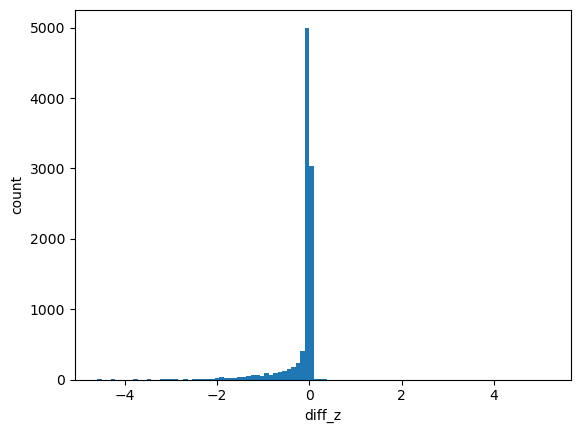

In [35]:
# Cut used previously by Bloom:
qso_X = qso.drop(columns=['ra', 'dec', 'class', 'spec_z'])
#qso_X = qso[column_subset]  # Bloom dropped many more features. Can debate whether should.
cut = (qso_X['dered_r'] > -9999) & (qso_X['g_r_color'] > -10) & (qso_X['g_r_color'] < 10) & (qso_X['diff_u'] > -5)
qso_X = qso_X[cut]
qso_y = qso_y[cut]

# I decided to inspect all of the histograms:
for col in qso_X.columns:
    plt.figure()
    plt.hist(qso_X[col], 100);
    plt.xlabel(col)
    plt.ylabel('count');

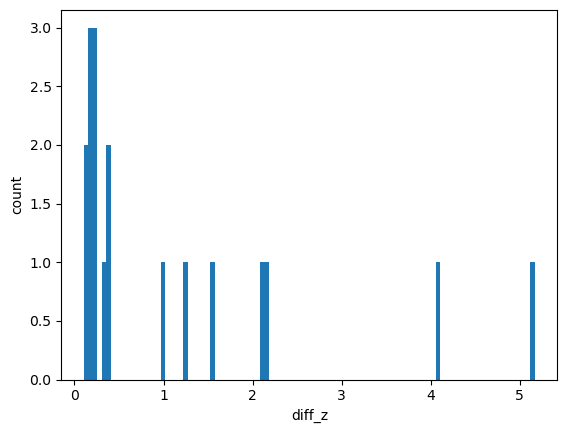

In [36]:
# diff_z looks suspiciously as if it should be -ve, but has some error, and some outliers:
# What is diff_z? The SQL statement said "... dered_z - mag_z AS diff_z ..."
# Are positive diff_* quantities unphysical?
plt.hist(qso_X['diff_z'][qso_X['diff_z'] > 0.1], 100)
plt.xlabel('diff_z'); plt.ylabel('count');

Looking at 84% of cases


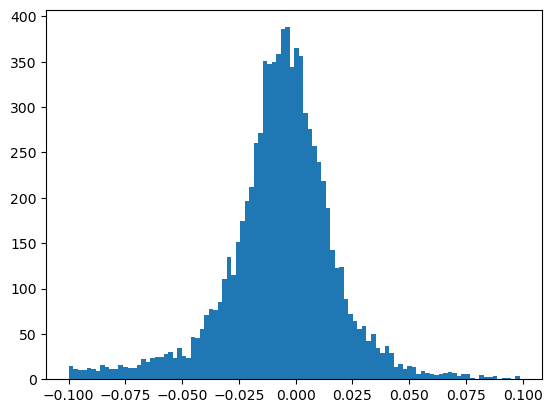

In [37]:
# Distribution on diff_u exceedingly sharp, but doesn't have "atom" at zero:
plt.hist(qso_X['diff_u'][abs(qso_X['diff_u']) < 0.1], 100);
print('Looking at %0.0f%% of cases' % (100.0 * (abs(qso_X['diff_u']) < 0.1).sum() / len(qso_X)))

In [38]:
# Standardizing inputs. Often, but not always, a useful default.
qso_X = qso_X - qso_X.mean(axis=0).values
qso_X = qso_X / qso_X.std(axis=0).values

## Dataset splits

**This part is important.** We split our data into training, validation, and test splits.

Good training error might not mean anything: it's easy to get zero training error (e.g., nearest neighbour regression with K=1). Validation sets (AKA "development sets") let us compare different models. However, it's easy to fool-yourself (make a fool of yourself) by making many random tweaks – when we start to fit the validation by making many comparisons, it's no longer representative of future performance(†). A held out test set should be used *at the end* to do a final comparison, of a small number of alternatives.

(†) Discuss: when/how can the validation set tell us about future performance?

In [39]:
N = len(qso_y)
N_val = int(N * 0.10)
N_test = int(N * 0.10)
N_train = N - N_val - N_test
qso_X_train = qso_X[:N_train]
qso_y_train = qso_y[:N_train]
qso_X_val = qso_X[N_train:(N_train + N_val)]
qso_y_val = qso_y[N_train:(N_train + N_val)]
# ...can fill in qso_X_test and qso_y_test when I need them...

## Fit some models

val error = 0.511 +/- 0.165
train error = 0.374 +/- 0.013


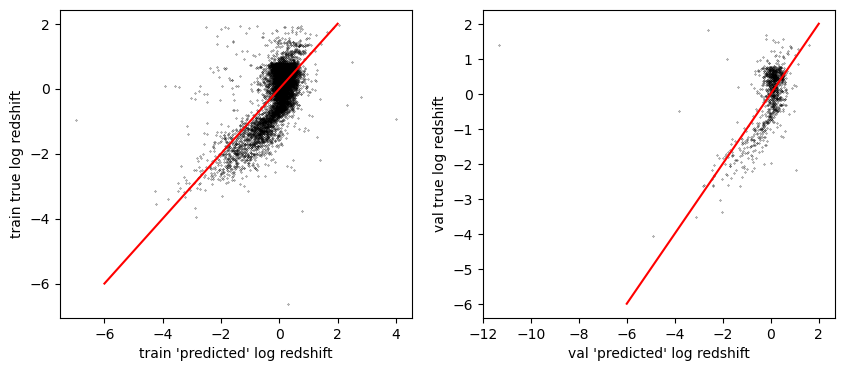

In [40]:
import scipy.stats
def mse_stderr(y1, y2):
    r2 = (y1 - y2) ** 2
    return np.mean(r2), scipy.stats.sem(r2)
    
y_train_true = qso_y_train.values
y_val_true = qso_y_val.values

def fit_and_evaluate(model):
    model.fit(qso_X_train, qso_y_train)
    y_val_pred = model.predict(qso_X_val)
    y_train_pred = model.predict(qso_X_train)
    
    plt.figure(figsize=[10,4])
    plt.subplot(1, 2, 1)
    plt.plot(y_train_pred, y_train_true, '.k', ms=0.5)
    plt.plot([-6, 2], [-6, 2], '-r')
    plt.xlabel("train 'predicted' log redshift"); plt.ylabel("train true log redshift");
    plt.subplot(1, 2, 2)
    plt.plot(y_val_pred, y_val_true, '.k', ms=0.5)
    plt.plot([-6, 2], [-6, 2], '-r')
    plt.xlabel("val 'predicted' log redshift"); plt.ylabel("val true log redshift");
    
    print('val error = %0.3f +/- %0.3f' % mse_stderr(y_val_true, y_val_pred))
    print('train error = %0.3f +/- %0.3f' % mse_stderr(y_train_true, y_train_pred))
    
    return y_val_pred

import sklearn.linear_model
fit_and_evaluate(sklearn.linear_model.Ridge(alpha=10.0));

val error = 0.265 +/- 0.036
train error = 0.000 +/- 0.000


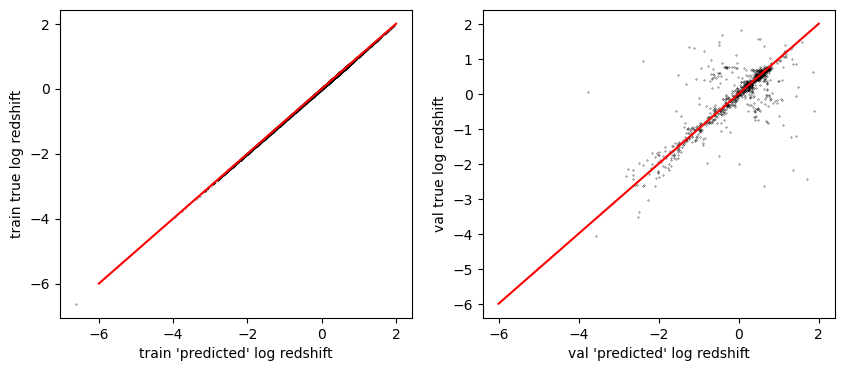

In [20]:
import sklearn.tree
fit_and_evaluate(sklearn.tree.DecisionTreeRegressor());

val error = 0.169 +/- 0.019
train error = 0.133 +/- 0.007


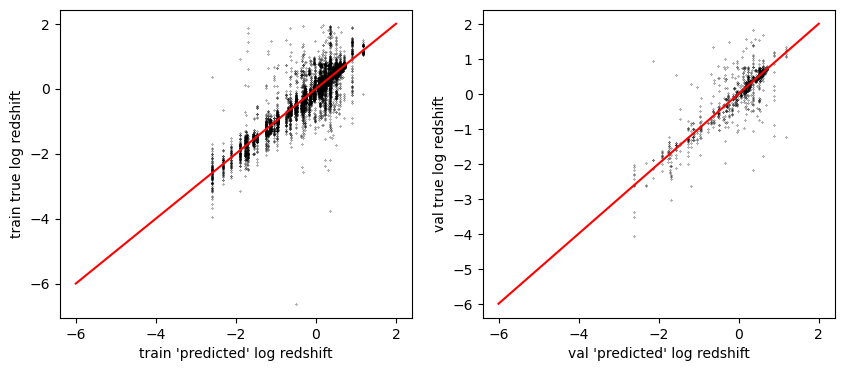

In [21]:
import sklearn.tree
val_pred_single_tree = fit_and_evaluate(sklearn.tree.DecisionTreeRegressor(min_samples_leaf=50));

val error = 0.136 +/- 0.019
train error = 0.024 +/- 0.002


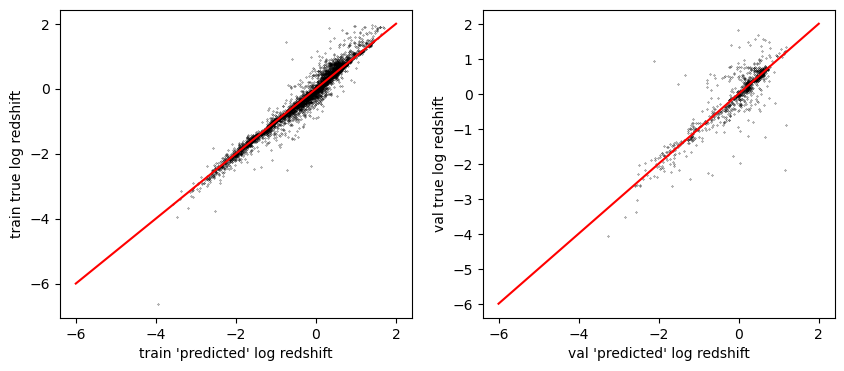

In [22]:
# The version of sklearn I have installed calls something that's going to be deprecated from Numpy.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sklearn.ensemble
val_pred_ensemble = fit_and_evaluate(sklearn.ensemble.RandomForestRegressor(10));

In [23]:
ensemble_losses = (val_pred_ensemble - y_val_true)**2
single_tree_losses = (val_pred_single_tree - y_val_true)**2

differences = single_tree_losses - ensemble_losses
print('ensemble better by %0.3f +/- %0.3f' % (differences.mean(), scipy.stats.sem(differences)))

ensemble better by 0.034 +/- 0.010


## Understanding the residuals

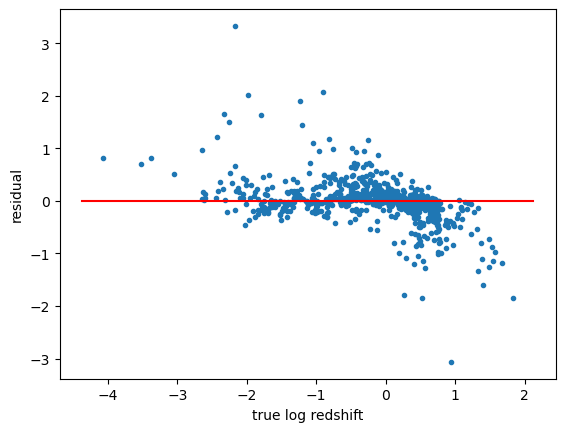

In [24]:
plt.plot(y_val_true, val_pred_ensemble - y_val_true, '.')
plt.plot(plt.xlim(), [0,0], 'r-')
plt.xlabel('true log redshift'); plt.ylabel('residual');

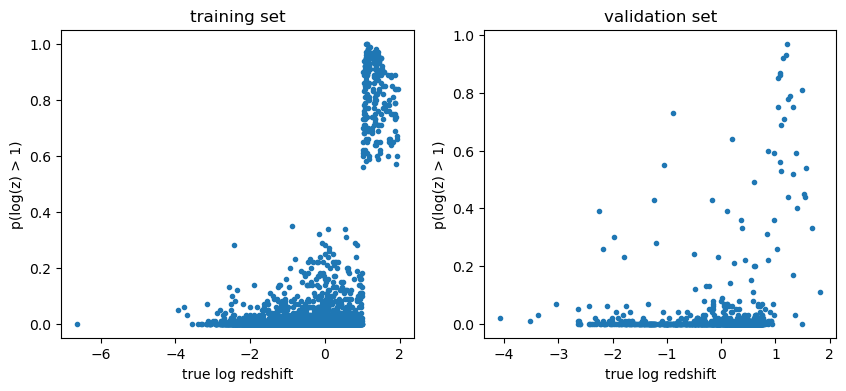

In [25]:
#model = sklearn.linear_model.LogisticRegression(C=(1 / 10.0))
model = sklearn.ensemble.RandomForestClassifier(100)
threshold = 1.0
model.fit(qso_X_train, qso_y_train > threshold)

y_train_pred = model.predict_proba(qso_X_train)[:,1]
y_val_pred = model.predict_proba(qso_X_val)[:,1]

plt.figure(figsize=(10,4))
plt.clf()
plt.subplot(1, 2, 1)
plt.title('training set');
plt.plot(y_train_true, y_train_pred, '.')
plt.xlabel('true log redshift'); plt.ylabel('p(log(z) > %g)' % threshold)
plt.subplot(1, 2, 2)
plt.title('validation set')
plt.plot(y_val_true, y_val_pred, '.');
plt.xlabel('true log redshift'); plt.ylabel('p(log(z) > %g)' % threshold);